In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
#from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight

In [41]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [42]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [43]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/img2.png')
    plt.show()
   
    
    return fig

In [44]:
def loadImages(path_data, path_labels):

    image_list = []
    

    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = path_labels    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [45]:
def normalization(data, norm_mean):#, norm_sigma):
    
    x_scaled = (data - norm_mean)# / norm_sigma
    data = x_scaled
    
    return data

In [46]:
def resize(x_o):
    rescaled = []

    for i in x_o:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [48]:
train_data = '/home/jovyan/DATA_MASTER_PROJECT/A549/Cropped_test/*.tiff'
train_lab='/home/jovyan/DATA_MASTER_PROJECT/A549/test_labels.csv'


test_data='/home/jovyan/DATA_MASTER_PROJECT/A549/Cropped_train/*.tiff'
test_lab='/home/jovyan/DATA_MASTER_PROJECT/A549/train_labels.csv'

In [49]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages(train_data, train_lab))
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 2364.32it/s]


((23094, 90, 90, 3), (23094,))

In [50]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

((8575, 90, 90, 3), (8575,))

In [51]:
x_test = x_test/255
x_orig_1 = x_orig_1/255

In [52]:
x_test = resize(x_test)
x_test.shape

(8575, 64, 64, 3)

In [53]:
x_orig_1 = resize(x_orig_1)

x_orig_1.shape

(23094, 64, 64, 3)

In [54]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((18475, 64, 64, 3), (4619, 64, 64, 3), (18475,), (4619,))

In [55]:
pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

In [56]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 6710, 1: 5768, 2: 5997}

In [57]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 1639, 1: 1497, 2: 1483}

In [58]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1877, 1: 3700, 2: 2998}

In [59]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [0.9177844  1.06767221 1.02690234]


In [60]:
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

y_train_1.shape, y_test_1.shape, y_val.shape

((18475, 3), (8575, 3), (4619, 3))

In [61]:
#print('Shape:{0}\nMean:{1}\nSigma:{2}'.format(x_train_1.shape,np.mean(x_train_1),np.std(x_train_1)))

In [62]:
norm_mean = np.mean(x_train_1)
norm_sigma = np.std(x_train_1)

x_train_1 = normalization(x_train_1, norm_mean)#, norm_sigma)

x_val = normalization(x_val, norm_mean)#, norm_sigma)

x_test = normalization(x_test, norm_mean)#, norm_sigma)


In [63]:
batch_size = 32

In [64]:
datagen = ImageDataGenerator()

datagen.fit(x_train_1)

train_gen = datagen.flow(x_train_1, y_train_1, batch_size=batch_size)

In [65]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val, batch_size=batch_size)

In [66]:
m4 = Sequential()
m4.add(base_model)


m4.add(BatchNormalization())
m4.add(GlobalAveragePooling2D())
m4.add(Dense(64, activation='relu'))
m4.add(Dense(3, activation = 'softmax'))

m4.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 256)         1735488   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,753,155
Trainable params: 1,752,643
Non-trainable params: 512
_________________________________________________________________


In [67]:
base_model.trainable = False

opt = keras.optimizers.Adam(lr=1e-3)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [68]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 577.34375 steps, validate for 144.34375 steps
Epoch 1/100
578/577 [==============================] - 7s 12ms/step - loss: 0.9833 - accuracy: 0.5084 - val_loss: 0.9206 - val_accuracy: 0.5696
Epoch 2/100
578/577 [==============================] - 6s 11ms/step - loss: 0.8969 - accuracy: 0.5798 - val_loss: 0.8702 - val_accuracy: 0.6012
Epoch 3/100
578/577 [==============================] - 6s 11ms/step - loss: 0.8438 - accuracy: 0.6149 - val_loss: 0.8216 - val_accuracy: 0.6300
Epoch 4/100
578/577 [==============================] - 7s 11ms/step - loss: 0.8027 - accuracy: 0.6415 - val_loss: 0.7932 - val_accuracy: 0.6443
Epoch 5/100
578/577 [==============================] - 6s 11ms/step - loss: 0.7709 - accuracy: 0.6554 - val_loss: 0.7764 - val_accuracy: 0.6575
Epoch 6/100
578/577 [==============================] - 6s 11ms/step - loss: 0.7458 - accuracy: 0.6701 - val_loss: 0.7625 - val_accuracy: 0.6620
Epoch 7/100
578/577 [=========

In [69]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-4)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

In [70]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 577.34375 steps, validate for 144.34375 steps
Epoch 1/100
578/577 [==============================] - 13s 23ms/step - loss: 0.7288 - accuracy: 0.6966 - val_loss: 1.8245 - val_accuracy: 0.4516
Epoch 2/100
578/577 [==============================] - 12s 20ms/step - loss: 0.5783 - accuracy: 0.7566 - val_loss: 1.9281 - val_accuracy: 0.5228
Epoch 3/100
578/577 [==============================] - 12s 20ms/step - loss: 0.4857 - accuracy: 0.7986 - val_loss: 2.3956 - val_accuracy: 0.4551
Epoch 4/100
578/577 [==============================] - 12s 21ms/step - loss: 0.4256 - accuracy: 0.8304 - val_loss: 2.3213 - val_accuracy: 0.4525
Epoch 00004: early stopping


In [71]:
base_model.trainable = True

opt = keras.optimizers.Adam(lr=1e-5)

m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

In [72]:

epochs = 100

m4_h = m4.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 577.34375 steps, validate for 144.34375 steps
Epoch 1/100
578/577 [==============================] - 13s 22ms/step - loss: 0.2706 - accuracy: 0.9076 - val_loss: 0.5255 - val_accuracy: 0.7848
Epoch 2/100
578/577 [==============================] - 12s 21ms/step - loss: 0.2327 - accuracy: 0.9264 - val_loss: 0.5195 - val_accuracy: 0.7909
Epoch 3/100
578/577 [==============================] - 12s 20ms/step - loss: 0.2136 - accuracy: 0.9364 - val_loss: 0.5504 - val_accuracy: 0.7816
Epoch 4/100
578/577 [==============================] - 12s 20ms/step - loss: 0.1979 - accuracy: 0.9437 - val_loss: 0.4947 - val_accuracy: 0.8062
Epoch 5/100
578/577 [==============================] - 12s 20ms/step - loss: 0.1846 - accuracy: 0.9494 - val_loss: 0.5235 - val_accuracy: 0.7891
Epoch 6/100
578/577 [==============================] - 12s 20ms/step - loss: 0.1721 - accuracy: 0.9543 - val_loss: 0.5303 - val_accuracy: 0.7928
Epoch 7/100
578/577 [===

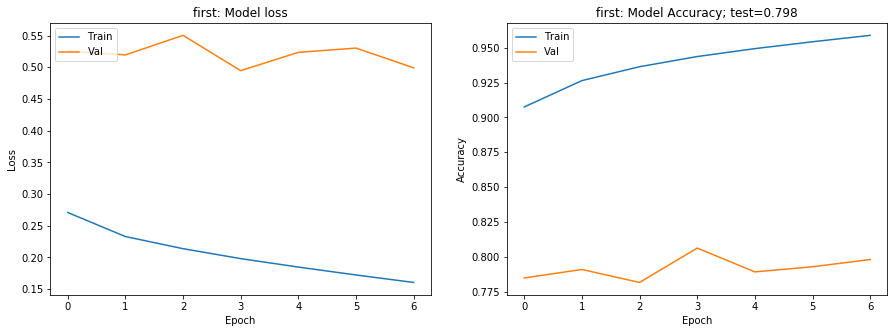

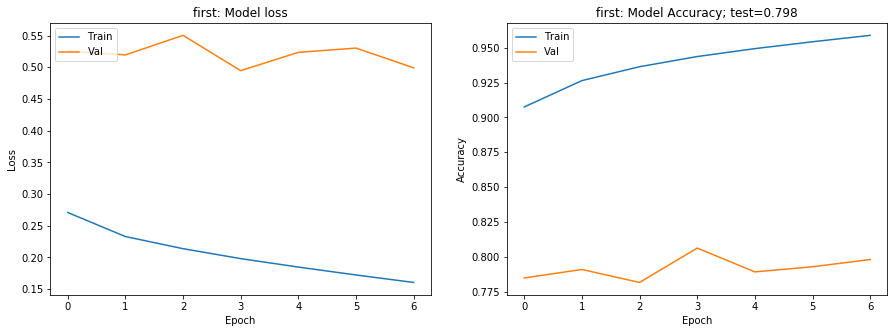

In [73]:
plot_history(m4_h, 'first')


In [74]:
scores = m4.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m4.metrics_names[1], scores[1]*100))

8575/8575 [==============================] - 2s 253us/sample - loss: 2.0752 - accuracy: 0.3317

accuracy: 33.17%


In [75]:
test_preds = m4.predict(x_test)

In [76]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

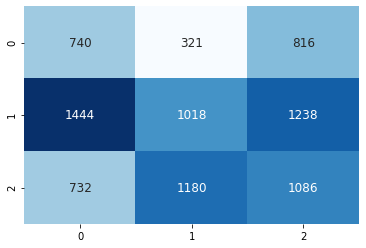

array([[ 740,  321,  816],
       [1444, 1018, 1238],
       [ 732, 1180, 1086]])

In [77]:
draw_confusion_matrix(y_test, predicted_labels)

In [78]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.25      0.39      0.31      1877
           1       0.40      0.28      0.33      3700
           2       0.35      0.36      0.35      2998

    accuracy                           0.33      8575
   macro avg       0.33      0.34      0.33      8575
weighted avg       0.35      0.33      0.33      8575



In [79]:
# p = '/home/jovyan/Saved_Models/'
# m4.save(p + "CNN_T10_P010726_model_5.h5")